In [1]:
import torchvision

In [2]:
import torch
from torch.utils.data import Dataset
from typing import Tuple
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt


#### LOADING THE MODEL

from torchvision.models import resnet18


device = "cpu"


model = resnet18(weights=False)
model.fc = torch.nn.Linear(512, 44)

ckpt = torch.load("./01_MIA_67.pt", map_location="cpu")

model.load_state_dict(ckpt)

model = model.to(device=device)
#### DATASETS

class TaskDataset(Dataset):
    def __init__(self, transform=None):

        self.ids = []
        self.imgs = []
        self.labels = []

        self.transform = transform


    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        id_ = self.ids[index]
        img = self.imgs[index]
        if not self.transform is None:
            img = self.transform(img)
        label = self.labels[index]
        return id_, img, label


    def __len__(self):
        return len(self.ids)


class MembershipDataset(TaskDataset):
    def __init__(self, transform=None):
        super().__init__(transform)
        self.membership = []

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int, int]:
        id_, img, label = super().__getitem__(index)
        return id_, img, label, self.membership[index]


#data: MembershipDataset = torch.load("./priv_out.pt")

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
data: MembershipDataset = torch.load("./pub.pt")

In [4]:
mean = [0.2980, 0.2962, 0.2987]
std = [0.2886, 0.2875, 0.2889]

transform = torchvision.transforms.Normalize(mean=mean, std=std)

# perform the transform on the images
data.transform = torchvision.transforms.Compose([
    transform
])

# make a dataloader
train_loader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=False)

# threshold analysis

In [17]:

confidence_scores_original = []
confidence_scores_prediction = []

label_predicted = []
labels = []


memebership = []

model.eval()  # put model in evaluation mode

for i in range(len(data)):
    id_, img, label, member_status = data[i] # get image and label from dataset
    img=img.to(device=device)  # move image to device
    img = img.unsqueeze(0)  # add batch dimension
    score = model(img)  # get model's score
    score = score.to(device="cpu")  # move score to cpu
    confidence_score = torch.nn.functional.softmax(score, dim=1)

    label_pred = torch.argmax(confidence_score).item()


    confidence_scores_prediction.append(confidence_score[0][label_pred].item())
    confidence_scores_original.append(confidence_score[0][label].item())


    label_predicted.append(label_pred)
    labels.append(label)
    memebership.append(member_status)

In [18]:
label_predicted,labels,memebership==1

([17,
  21,
  36,
  41,
  33,
  21,
  19,
  5,
  6,
  22,
  20,
  41,
  5,
  25,
  21,
  37,
  21,
  21,
  21,
  22,
  11,
  31,
  21,
  22,
  31,
  6,
  41,
  19,
  6,
  17,
  20,
  6,
  11,
  2,
  22,
  41,
  41,
  40,
  6,
  17,
  17,
  17,
  11,
  6,
  11,
  11,
  21,
  37,
  11,
  37,
  21,
  22,
  12,
  17,
  23,
  20,
  15,
  21,
  41,
  11,
  29,
  20,
  25,
  41,
  20,
  21,
  11,
  20,
  15,
  41,
  21,
  29,
  5,
  20,
  43,
  22,
  38,
  11,
  41,
  41,
  11,
  4,
  41,
  20,
  29,
  40,
  21,
  17,
  21,
  22,
  6,
  11,
  17,
  15,
  21,
  21,
  29,
  11,
  27,
  33,
  6,
  41,
  22,
  15,
  41,
  5,
  17,
  5,
  20,
  22,
  38,
  21,
  4,
  37,
  27,
  41,
  40,
  6,
  25,
  29,
  14,
  41,
  11,
  40,
  11,
  22,
  12,
  41,
  27,
  41,
  6,
  41,
  11,
  37,
  36,
  6,
  6,
  17,
  31,
  11,
  22,
  36,
  41,
  22,
  37,
  12,
  20,
  20,
  17,
  36,
  21,
  21,
  40,
  17,
  15,
  17,
  41,
  41,
  22,
  12,
  41,
  41,
  29,
  25,
  12,
  17,
  6,
  36,
  12,
  21,
 

In [19]:
np.array(memebership)==1

array([False,  True,  True, ..., False,  True, False])

In [20]:
# make a df with the results
df = pd.DataFrame(data={"label_predicted": label_predicted, "labels": labels, "memebership": memebership, "confidence_scores_original": confidence_scores_original, "confidence_scores_prediction": confidence_scores_prediction})
# save the df
df.to_csv("results.csv")

In [21]:
df

,label_predicted,labels,memebership,confidence_scores_original,confidence_scores_prediction
0,17,17,0,0.668097,0.668097
1,21,21,1,0.880674,0.880674
2,36,36,1,0.889931,0.889931
3,41,41,0,0.801179,0.801179
4,33,33,0,1.000000,1.000000
...,...,...,...,...,...
19995,25,25,1,0.527543,0.527543
19996,40,40,1,0.649194,0.649194
19997,41,41,0,0.988427,0.988427
19998,17,17,1,0.482753,0.482753


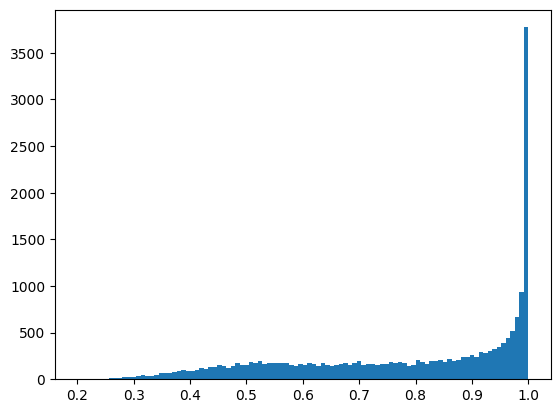

In [22]:
plt.hist(df['confidence_scores_prediction'],bins=100)
plt.show()

In [157]:
(confidence_scores > 0.95).astype(int).sum()

6812

In [146]:
preds

array([False, False, False, ..., False, False, False])

(array([10000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 10000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

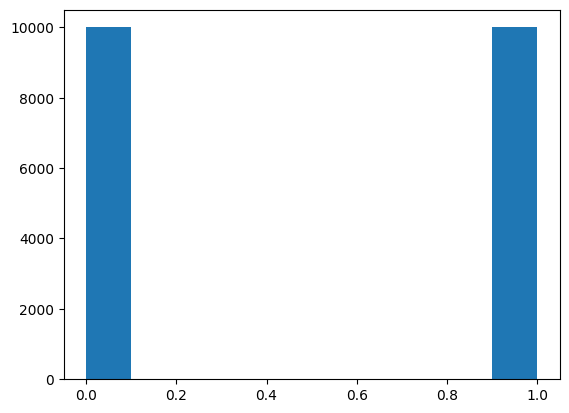

In [152]:
plt.hist((memebership==1 & preds).astype(int))

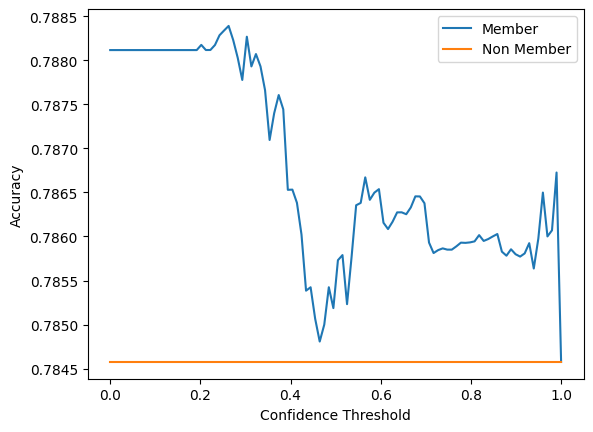

In [24]:
# Assuming `confidence_scores` is a list of confidence scores for each prediction,
# and `labels` is a list of true labels for each data point

# Convert lists to numpy arrays
confidence_scores = np.array(confidence_scores_prediction)
labels = np.array(labels)
label_predicted = np.array(label_predicted)
memebership = np.array(memebership)

# Calculate accuracy at different confidence thresholds
thresholds = np.linspace(0, 1, 100)
accuracies_m = []
accuracies_nm = []

for threshold in thresholds:
    # Get predictions where confidence score is above the threshold
    preds = confidence_scores > threshold

    # Calculate accuracy
    accuracy_members = np.mean(confidence_scores[memebership==1 & preds])
    accuracy_nonmembers = np.mean(confidence_scores[memebership==0  & preds])
    
    
    accuracies_m.append(accuracy_members)
    accuracies_nm.append(accuracy_nonmembers)


# Plot accuracy vs confidence threshold
plt.plot(thresholds, accuracies_m,label="Member")
plt.plot(thresholds, accuracies_nm,label="Non Member")
plt.xlabel('Confidence Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Find the statistics of how frequent a nodes in the neural network  is activated for a given set of images. Our approach is there are certain neurons which hold information about bias of the training dataset, which we can leverage to predict whether a data point was a memeber or not.

In [5]:
class InputStorer:
    """
    Attributes:
      inputs:
      inputs_count:
      label:
    """

    def __init__(self):
        self.inputs = {label: torch.zeros(512) for label in range(44)}  # Assuming 44 classes
        self.inputs_count = {label:0 for label in range(44)}
        self.label = None
        self.memeber_inputs =  {label: torch.zeros(512) for label in range(2)}  # 2 classes wheather a member or not
        self.member_status = None
        self.model_prediction = []
        self.labels = []
        self.memeber_counts = {label:0 for label in range(2)}

    def store_inputs(self, module, input, output):
        if module == model.fc:  # Only store inputs for the second layer
            for i, inp in enumerate(input[0]):  # Iterate over the batch
                label = self.label[i].item() # Get the label for the current image
                self.inputs[label]+=inp
                self.inputs_count[label]+=1

                member = self.member_status[i].item()
                self.memeber_inputs[member]+=inp
                self.memeber_counts[member]+=1

input_storer = InputStorer()

# Register the hooks and store the handles
handle1 = model.fc.register_forward_hook(input_storer.store_inputs)

# Forward pass
for  id_, img, label, member_status  in train_loader:
    input_storer.label = label
    input_storer.member_status = member_status
    output = model(img)
    input_storer.labels.extend(label)
    input_storer.model_prediction.extend(torch.argmax(output,axis=1))

# Remove the hooks
handle1.remove()

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [6]:
input_storer.memeber_counts

{0: 10000, 1: 10000}

In [9]:
input_storer.memeber_inputs[0] = input_storer.memeber_inputs[0]/10000 # not member
input_storer.memeber_inputs[1] = input_storer.memeber_inputs[1]/10000 # member

In [19]:
diff = []
for neuron in range(512):
  diff.append((input_storer.memeber_inputs[0][neuron] - input_storer.memeber_inputs[1][neuron]).item())

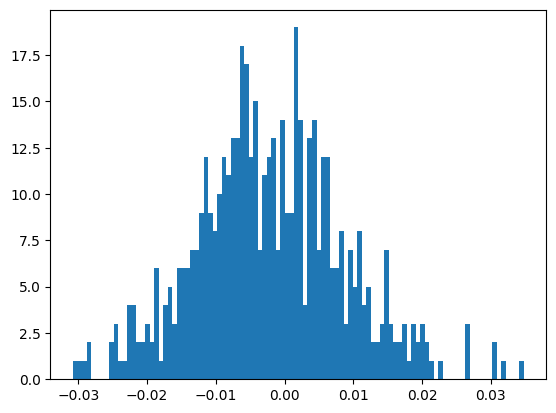

In [24]:
plt.hist(diff,bins=100)
plt.show()

In [32]:
non_member_coders = []
member_coders = []

for i in range(512):
  if diff[i]>0.02:
    non_member_coders.append(i)
  elif diff[i]<-0.02:
    member_coders.append(i)


In [37]:
member_coders,non_member_coders

([7,
  48,
  88,
  117,
  123,
  129,
  167,
  182,
  190,
  283,
  309,
  315,
  329,
  342,
  356,
  357,
  358,
  376,
  416,
  428,
  443,
  473,
  482,
  484,
  503],
 [5, 34, 175, 217, 248, 352, 365, 378, 408, 415, 422, 490, 496])

# Using these coders for detecting members and non-members

In [83]:
member_coders = [7,
  48,
  88,
  117,
  123,
  129,
  167,
  182,
  190,
  283,
  309,
  315,
  329,
  342,
  356,
  357,
  358,
  376,
  416,
  428,
  443,
  473,
  482,
  484,
  503]
non_member_coders = [5, 34, 175, 217, 248, 352, 365, 378, 408, 415, 422, 490, 496]

In [111]:
data : TaskDataset =  torch.load("/content/drive/MyDrive/TML/priv_out.pt")

In [112]:
len(data)

20000

In [114]:
mean = [0.2980, 0.2962, 0.2987]
std = [0.2886, 0.2875, 0.2889]

transform = torchvision.transforms.Normalize(mean=mean, std=std)

In [113]:
data.transform = transform

In [115]:
for i in data:
  print(i)
  break

(55061, tensor([[[1.9025, 1.9297, 1.8889,  ..., 1.7258, 1.8074, 1.8617],
         [1.7938, 1.8345, 1.8345,  ..., 1.8481, 1.9297, 1.8617],
         [1.8889, 1.8617, 1.8617,  ..., 1.8481, 1.8210, 1.7530],
         ...,
         [1.8617, 1.8617, 1.8753,  ..., 1.2910, 1.6035, 1.6579],
         [1.8210, 1.8481, 1.8753,  ..., 1.7394, 1.8481, 1.8889],
         [1.2638, 1.5628, 1.7666,  ..., 1.7666, 1.7258, 1.7123]],

        [[0.9203, 0.9067, 0.7975,  ..., 0.5247, 0.6475, 0.7157],
         [0.5111, 0.5111, 0.4565,  ..., 0.6338, 0.7020, 0.6202],
         [0.5656, 0.5793, 0.5929,  ..., 0.6611, 0.6338, 0.5793],
         ...,
         [0.7430, 0.6748, 0.6748,  ..., 0.3201, 0.5656, 0.6066],
         [0.6475, 0.6475, 0.6338,  ..., 0.5247, 0.6066, 0.6338],
         [0.2656, 0.4156, 0.5247,  ..., 0.4838, 0.4156, 0.4156]],

        [[1.5452, 1.5180, 1.4230,  ..., 1.2330, 1.3416, 1.3958],
         [1.2330, 1.2330, 1.1922,  ..., 1.3416, 1.3958, 1.3416],
         [1.2737, 1.2737, 1.2873,  ..., 1.3551, 1.

In [118]:
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [119]:
model(i[1])

ValueError: expected 4D input (got 3D input)

In [19]:
class InputStorer:
    """
    Attributes:
      inputs:
      inputs_count:
      label:
    """

    def __init__(self):
        self.inputs_members = []
        self.inputs_non_members = []
        self.member_coders = None
        self.non_member_coders = None


    def store_inputs(self, module, input, output):
        if module == model.fc:  # Only store inputs for the second layer
            for i, inp in enumerate(input[0]):  # Iterate over the batch
                self.inputs_members.append(inp[self.member_coders])
                self.inputs_non_members.append(inp[self.non_member_coders])



input_storer = InputStorer()
input_storer.non_member_coders = non_member_coders
input_storer.member_coders = member_coders

# Register the hooks and store the handles
handle1 = model.fc.register_forward_hook(input_storer.store_inputs)

model.eval()
# Forward pass
for  id_, img, label,_ in data:
    output = model(img)

# Remove the hooks
handle1.remove()

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>

In [14]:
id_, img.shape

(55061, torch.Size([3, 32, 32]))

In [8]:
# Assuming `data` is your original dataset

# Separate the data into two datasets based on the membership flag
data1 = [item for item in data if item[3] == 1]  # membership is 1
data2 = [item for item in data if item[3] == 0]  # membership is 0

# The rest of the code remains the same

In [ ]:
import torch

# Assuming `model` is your trained ResNet model and `data1` and `data2` are your datasets

# Create a dictionary to store the outputs
outputs1 = {}
outputs2 = {}

# Define a hook function to record the outputs
def hook1(module, input, output):
    if str(module) not in outputs1:
        outputs1[str(module)] = output.detach()
    else:
        outputs1[str(module)] += output.detach()

def hook2(module, input, output):
    if str(module) not in outputs2:
        outputs2[str(module)] = output.detach()
    else:
        outputs2[str(module)] += output.detach()

# Register the hook for each module in the model
for name, module in model.named_modules():
    module.register_forward_hook(hook1)

# Run the first dataset through the model and record the outputs
for i in range(len(data1)):
    id_, img, label, member_status = data1[i]
    img = img.unsqueeze(0)  # add batch dimension, if your model expects it
    score = model(img)  # get model's score

# Register the hook for each module in the model
for name, module in model.named_modules():
    module.register_forward_hook(hook2)

# Run the second dataset through the model and record the outputs
for i in range(len(data2)):
    id_, img, label, member_status = data2[i]
    img = img.unsqueeze(0)  # add batch dimension, if your model expects it
    score = model(img)  # get model's score

# Now `outputs1` and `outputs2` are dictionaries where the keys are the names of the modules in the model
# and the values are the outputs of each module for the first and second dataset, respectively

# Calculate the average output for each module
for module in outputs1.keys():
    outputs1[module] /= len(data1)

for module in outputs2.keys():
    outputs2[module] /= len(data2)


RuntimeError: The size of tensor a (16) must match the size of tensor b (8) at non-singleton dimension 3

In [ ]:
# Compare the outputs to find differentially expressed nodes
# For example, you can use a t-test to compare the means of the outputs
from scipy.stats import ttest_ind

for module in outputs1.keys():
    output1 = outputs1[module].detach().numpy().flatten()
    output2 = outputs2[module].detach().numpy().flatten()
    t_stat, p_val = ttest_ind(output1, output2)
    print(output2==output1)
    if p_val < 0.9:
        print(f"{module} is differentially expressed")

[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  Tr

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_stats_py.py:1088: RuntimeWarning: overflow encountered in square
  s = a_zero_mean**2


In [ ]:
output1

array([-1.68020492e+21, -1.48304985e+21, -1.27003001e+21, -1.48804040e+21,
       -1.45327318e+21,  7.01796563e+20, -1.08912105e+21, -1.22357313e+21,
       -1.26871862e+21, -1.55413763e+21,  1.06037412e+20, -8.44010986e+19,
       -2.26487250e+21, -3.30240714e+19, -5.73946864e+20, -1.50921084e+21,
       -6.63400632e+20, -1.30215757e+21, -1.27848468e+21, -7.89705491e+20,
       -6.55644237e+20, -2.33034442e+21, -1.59635592e+21, -1.27228139e+21,
       -4.73492773e+20, -1.21143579e+21, -4.88741398e+20, -1.20397023e+21,
       -6.62688571e+20,  1.20946786e+21, -3.00121371e+21,  8.18355703e+20,
       -1.38771597e+21, -1.02203458e+21, -8.73412490e+20, -5.85041024e+20,
       -1.08890199e+21, -2.39911344e+20, -1.02478994e+21, -9.53912644e+20,
       -4.39335714e+20, -1.64969683e+21, -1.55897914e+21, -2.30722744e+21],
      dtype=float32)

In [ ]:
output2

array([-1.68020492e+21, -1.48304985e+21, -1.27003001e+21, -1.48804040e+21,
       -1.45327318e+21,  7.01796563e+20, -1.08912105e+21, -1.22357313e+21,
       -1.26871862e+21, -1.55413763e+21,  1.06037412e+20, -8.44010986e+19,
       -2.26487250e+21, -3.30240714e+19, -5.73946864e+20, -1.50921084e+21,
       -6.63400632e+20, -1.30215757e+21, -1.27848468e+21, -7.89705491e+20,
       -6.55644237e+20, -2.33034442e+21, -1.59635592e+21, -1.27228139e+21,
       -4.73492773e+20, -1.21143579e+21, -4.88741398e+20, -1.20397023e+21,
       -6.62688571e+20,  1.20946786e+21, -3.00121371e+21,  8.18355703e+20,
       -1.38771597e+21, -1.02203458e+21, -8.73412490e+20, -5.85041024e+20,
       -1.08890199e+21, -2.39911344e+20, -1.02478994e+21, -9.53912644e+20,
       -4.39335714e+20, -1.64969683e+21, -1.55897914e+21, -2.30722744e+21],
      dtype=float32)